In [1]:
import cptac
import pandas as pd
import scipy.stats as stats
import cptac.utils as ut
import scipy
import statsmodels.stats.multitest as ssm
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

cptac warning: Your version of cptac (0.8.8) is out-of-date. Latest is 0.9.1. Please run 'pip install --upgrade cptac' to update it. (<ipython-input-1-15f14e356ee3>, line 1)


In [2]:
ccrcc = cptac.Ccrcc()

In [3]:
cancer = ccrcc
cancer_name = 'ccrcc'

# ccrcc paper method/wilcoxon rank sum test

In [4]:
prot_normal_df = cancer.get_proteomics('normal')
if isinstance(prot_normal_df.columns, pd.MultiIndex):
    prot_normal_df = ut.reduce_multiindex(df= prot_normal_df, levels_to_drop = 'Database_ID')
prot_normal_df.reset_index(inplace = True)
prot_normal_df = prot_normal_df.melt(id_vars = 'Patient_ID', var_name = 'Gene', value_name = 'Proteomic')
prot_normal_df['Tissue'] = ['normal'] * len(prot_normal_df)
prot_tumor_df = cancer.get_proteomics('tumor')
if(isinstance(prot_tumor_df.columns, pd.MultiIndex)):
    prot_tumor_df = ut.reduce_multiindex(df= prot_tumor_df, levels_to_drop = 'Database_ID')
prot_tumor_df.reset_index(inplace = True)
prot_tumor_df = prot_tumor_df.melt(id_vars = 'Patient_ID', var_name = 'Gene', value_name = 'Proteomic')
prot_tumor_df['Tissue'] = ['tumor'] * len(prot_tumor_df)
prot_df = pd.merge(prot_tumor_df, prot_normal_df, how = 'outer')
prot_df = prot_df.dropna()
prot_df

cptac warning: Due to dropping the specified levels, dataframe now has 907 duplicated column headers. (<ipython-input-4-ec808c4f66bb>, line 3)
cptac warning: Due to dropping the specified levels, dataframe now has 907 duplicated column headers. (<ipython-input-4-ec808c4f66bb>, line 9)


,Patient_ID,Gene,Proteomic,Tissue
0,C3L-00004,A1BG,-0.304302,tumor
1,C3L-00010,A1BG,1.195915,tumor
2,C3L-00011,A1BG,-0.286155,tumor
3,C3L-00026,A1BG,0.135730,tumor
4,C3L-00079,A1BG,-0.123959,tumor
...,...,...,...,...
2271733,C3N-01522.N,ZZZ3,0.089533,normal
2271736,C3N-01648.N,ZZZ3,0.200438,normal
2271737,C3N-01649.N,ZZZ3,0.111064,normal
2271738,C3N-01651.N,ZZZ3,0.185857,normal


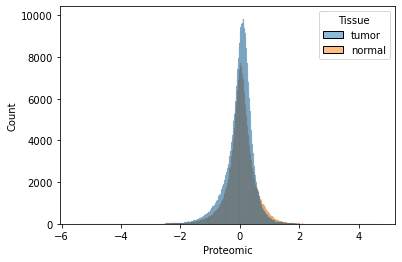

In [5]:
sns.histplot(data = prot_df, x = 'Proteomic', hue = 'Tissue')

From the ccrcc paper methods section:
"TMT-based global proteomic data were used to perform differential proteome analysis between tumor and normal samples (Figures 4B, S4B, and S4C; Table S5). A Wilcoxon rank sum test was performed to determine differential abundance of proteins between tumor and normal samples. The significantly differentially expressed gene lists (fold change > = 2 and FDR < 0.05)..."
From the results section:
"In total, 820 proteins showed significant differential expression in a group comparison of tissue samples (log2 fold-change >1; Benjamini-Hochberg adjusted p < 0.05)"
https://www-sciencedirect-com.erl.lib.byu.edu/science/article/pii/S0092867419311237?via%3Dihub#bib175

In [6]:
def log2_fold_change(tumor, normal):
    tumor = scipy.mean(tumor)
    normal = scipy.mean(normal)
    #return scipy.log2(abs(tumor - normal))
    if normal == 0 or tumor == 0:
        return(float('Nan'))
    fold_change = tumor / normal
    fold_change = abs(fold_change)
    log2_change = math.log2(fold_change)
    return log2_change    

In [7]:
fold_change = prot_df.groupby('Gene').apply(
    lambda df: log2_fold_change(df[df['Tissue']=='tumor'].Proteomic,
                                df[df['Tissue']=='normal'].Proteomic))
fold_change = pd.DataFrame(fold_change, columns = ['Log2_fold_change'])
fold_change.reset_index(inplace = True)
fold_change

<ipython-input-6-cb763c441e3f>:2: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  tumor = scipy.mean(tumor)
<ipython-input-6-cb763c441e3f>:3: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  normal = scipy.mean(normal)


,Gene,Log2_fold_change
0,A1BG,0.846625
1,A1CF,-0.218309
2,A2M,-1.256118
3,A4GALT,3.045874
4,AAAS,4.527650
...,...,...
11231,ZXDC,-0.986954
11232,ZYG11B,1.278968
11233,ZYX,7.760622
11234,ZZEF1,-0.183456


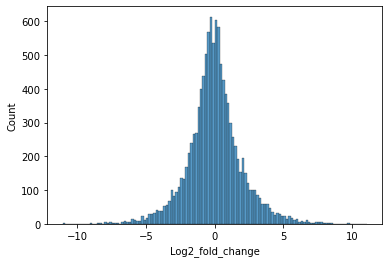

In [8]:
sns.histplot(data = fold_change, x = 'Log2_fold_change')

In [9]:
ranksums = prot_df.groupby('Gene').apply(lambda df: stats.ranksums(
    df[df['Tissue']=='tumor'].Proteomic,
    df[df['Tissue']=='normal'].Proteomic))
ranksums = pd.DataFrame.from_records(ranksums, index = ranksums.index, columns = ['statistic', 'pval'])
ranksums.reset_index(inplace = True)
ranksums = ranksums.dropna()
ranksums['FDR'] = ssm.fdrcorrection(ranksums['pval'])[1]
ranksums = pd.merge(ranksums, fold_change)
ranksums


C:\Users\nanel\anaconda3\lib\site-packages\scipy\stats\stats.py:7114: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
C:\Users\nanel\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,Gene,statistic,pval,FDR,Log2_fold_change
0,A1BG,4.062020,4.864990e-05,7.977389e-05,0.846625
1,A1CF,-6.998855,2.580621e-12,6.376757e-12,-0.218309
2,A2M,6.557556,5.469684e-11,1.261222e-10,-1.256118
3,A4GALT,0.979796,3.271869e-01,3.660405e-01,3.045874
4,AAAS,9.324065,1.119664e-20,4.340440e-20,4.527650
...,...,...,...,...,...
11206,ZXDC,-1.736330,8.250541e-02,1.008030e-01,-0.986954
11207,ZYG11B,3.729110,1.921574e-04,3.019731e-04,1.278968
11208,ZYX,3.774606,1.602608e-04,2.530184e-04,7.760622
11209,ZZEF1,-0.745822,4.557750e-01,4.960867e-01,-0.183456


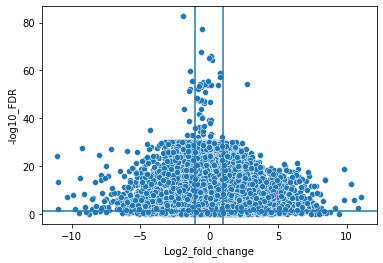

In [10]:
ranksums['-log10_FDR'] = - np.log10(ranksums.FDR)
sns.scatterplot(data = ranksums, x = 'Log2_fold_change', y = '-log10_FDR')
plt.axvline(x = -1)
plt.axvline(x = 1)
plt.axhline(y = -np.log10(0.05))

In [11]:
ranksums = ranksums[ranksums.FDR < 0.05]
ranksums = ranksums[np.array(ranksums.Log2_fold_change >= 2) |
                   np.array(ranksums.Log2_fold_change <= -2)]
print(len(ranksums))
ranksums

2305


,Gene,statistic,pval,FDR,Log2_fold_change,-log10_FDR
4,AAAS,9.324065,1.119664e-20,4.340440e-20,4.527650,19.362466
9,AAGAB,-3.344586,8.240556e-04,1.232784e-03,-2.298715,2.909113
14,AARS2,-3.091677,1.990291e-03,2.892928e-03,-2.676090,2.538662
15,AARSD1,7.995005,1.295685e-15,3.776892e-15,3.166629,14.422865
23,ABCA2,-3.145505,1.658004e-03,2.423137e-03,-2.033897,2.615622
...,...,...,...,...,...,...
11198,ZSCAN26,4.456234,8.341217e-06,1.439775e-05,2.917876,4.841705
11201,ZSWIM8,-10.820870,2.741613e-27,1.793245e-26,-2.621033,25.746360
11202,ZSWIM9,2.932127,3.366491e-03,4.790168e-03,-3.855613,2.319649
11203,ZW10,-5.845283,5.057080e-09,1.051074e-08,-4.067152,7.978367


# t-test for differential expression

In [12]:
prot_normal_df = cancer.get_proteomics('normal')
if isinstance(prot_normal_df.columns, pd.MultiIndex):
    prot_normal_df = ut.reduce_multiindex(df= prot_normal_df, levels_to_drop = 'Database_ID')
prot_normal_df.reset_index(inplace = True)
prot_normal_df = prot_normal_df.melt(id_vars = 'Patient_ID', var_name = 'Gene', value_name = 'Proteomic_normal')
#prot_normal_df['Tissue'] = ['normal'] * len(prot_normal_df)
prot_normal_df['Patient_ID'] = prot_normal_df.Patient_ID.str.strip('.N')
prot_tumor_df = cancer.get_proteomics('tumor')
if(isinstance(prot_tumor_df.columns, pd.MultiIndex)):
    prot_tumor_df = ut.reduce_multiindex(df= prot_tumor_df, levels_to_drop = 'Database_ID')
prot_tumor_df.reset_index(inplace = True)
prot_tumor_df = prot_tumor_df.melt(id_vars = 'Patient_ID', var_name = 'Gene', value_name = 'Proteomic_tumor')
#prot_tumor_df['Tissue'] = ['tumor'] * len(prot_tumor_df)
prot_df = pd.merge(prot_tumor_df, prot_normal_df, how = 'outer')
prot_df = prot_df.dropna()
prot_df

cptac warning: Due to dropping the specified levels, dataframe now has 907 duplicated column headers. (<ipython-input-12-7cb7bbe04826>, line 3)
cptac warning: Due to dropping the specified levels, dataframe now has 907 duplicated column headers. (<ipython-input-12-7cb7bbe04826>, line 10)


,Patient_ID,Gene,Proteomic_tumor,Proteomic_normal
0,C3L-00004,A1BG,-0.304302,0.291127
1,C3L-00010,A1BG,1.195915,-0.579658
2,C3L-00011,A1BG,-0.286155,-0.096200
3,C3L-00026,A1BG,0.135730,-0.209196
4,C3L-00079,A1BG,-0.123959,-0.395915
...,...,...,...,...
1376797,C3N-01522,ZZZ3,0.315745,0.089533
1376800,C3N-01648,ZZZ3,0.086113,0.200438
1376801,C3N-01649,ZZZ3,-0.127322,0.111064
1376802,C3N-01651,ZZZ3,-0.186567,0.185857


In [13]:
t_test = prot_df.groupby('Gene').apply(lambda df: stats.ttest_rel(df['Proteomic_tumor'], df['Proteomic_normal']))
t_test = pd.DataFrame.from_records(t_test, index = t_test.index, columns = [ 'T_score', 'pval'])
t_test.reset_index(inplace = True)
t_test = t_test.dropna()
t_test['qval'] = ssm.fdrcorrection(t_test['pval'])[1]


C:\Users\nanel\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\nanel\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nanel\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [14]:
t_test = pd.merge(t_test, fold_change)
t_test = t_test[np.array(t_test.qval < 0.05) & np.array(t_test.Log2_fold_change > 1)]                                               
t_test

,Gene,T_score,pval,qval,Log2_fold_change
4,AAAS,10.989705,7.300235e-18,2.678744e-17,4.527650
8,AAED1,5.955240,8.843564e-07,1.686853e-06,1.192466
12,AAR2,16.726048,2.591250e-28,1.986861e-27,1.431140
15,AARSD1,9.610860,3.922514e-15,1.227908e-14,3.166629
20,ABAT,-26.247650,5.918682e-42,2.988668e-40,1.024053
...,...,...,...,...,...
11192,ZRANB2,2.574905,1.180071e-02,1.624536e-02,1.995117
11193,ZRSR2,3.870592,3.639294e-04,5.751654e-04,2.347417
11197,ZSCAN26,6.043380,1.084664e-06,2.056679e-06,2.917876
11206,ZYG11B,3.846219,2.344385e-04,3.764583e-04,1.278968


# PCA Analysis

In [15]:
prot_normal_df = cancer.get_proteomics('normal')
if isinstance(prot_normal_df.columns, pd.MultiIndex):
    prot_normal_df = ut.reduce_multiindex(df= prot_normal_df, levels_to_drop = 'Database_ID')
    df = prot_normal_df
    cols=pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns=cols
    prot_normal_df = df
prot_tumor_df = cancer.get_proteomics('tumor')
if(isinstance(prot_tumor_df.columns, pd.MultiIndex)):
    prot_tumor_df = ut.reduce_multiindex(df= prot_tumor_df, levels_to_drop = 'Database_ID')
    df = prot_tumor_df
    cols=pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns=cols
    prot_tumor_df = df
prot_normal_df = prot_normal_df.dropna(thresh=len(prot_normal_df.index)/2 + 1, axis = 1)
prot_normal_df = prot_normal_df.dropna(thresh=len(prot_normal_df.columns)/2 + 1, axis = 0)
prot_tumor_df = prot_tumor_df.dropna(thresh=len(prot_tumor_df.index)/2 + 1, axis = 1)
prot_tumor_df = prot_tumor_df.dropna(thresh=len(prot_tumor_df.columns)/2 + 1, axis = 0)
genes = set(prot_tumor_df.columns).intersection(prot_normal_df.columns)
genes = list(genes)
prot_normal_df = prot_normal_df[genes]
prot_tumor_df = prot_tumor_df[genes]
prot_normal_df['Tissue'] = ['Normal'] * len(prot_normal_df)
prot_tumor_df['Tissue'] = ['Tumor'] * len(prot_tumor_df)
prot_pca_df = prot_tumor_df.append(prot_normal_df)
prot_pca_df = prot_pca_df.dropna(axis = 1)
prot_pca_df.reset_index(inplace = True)

cptac warning: Due to dropping the specified levels, dataframe now has 907 duplicated column headers. (<ipython-input-15-77109a38a27d>, line 3)
cptac warning: Due to dropping the specified levels, dataframe now has 907 duplicated column headers. (<ipython-input-15-77109a38a27d>, line 12)


In [16]:
features = prot_pca_df.columns[prot_pca_df.columns.isin(genes)]
x = prot_pca_df.loc[:,features].values
y = prot_pca_df.loc[:,['Tissue']].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, prot_pca_df[['Tissue']]], axis = 1)
finalDf

,principal component 1,principal component 2,Tissue
0,-46.631043,-14.160979,Tumor
1,-55.171290,-7.427117,Tumor
2,-43.765579,-10.940916,Tumor
3,-11.137117,-45.820473,Tumor
4,-52.239395,3.395097,Tumor
...,...,...,...
189,67.297854,4.233862,Normal
190,55.871578,9.935187,Normal
191,62.976833,-0.651640,Normal
192,67.363729,-16.311021,Normal


(-100.0, 100.0)

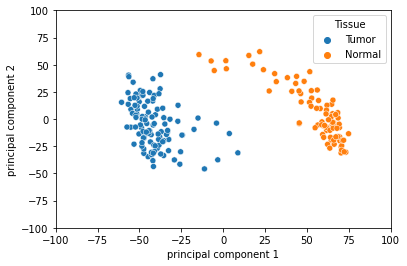

In [17]:
fig = sns.scatterplot(data = finalDf, x = 'principal component 1', y = 'principal component 2', hue = 'Tissue')
fig.set_xlim([-100,100])
fig.set_ylim([-100,100])